In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
base = automap_base()

# reflect the tables
base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = base.classes.measurement
Station = base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

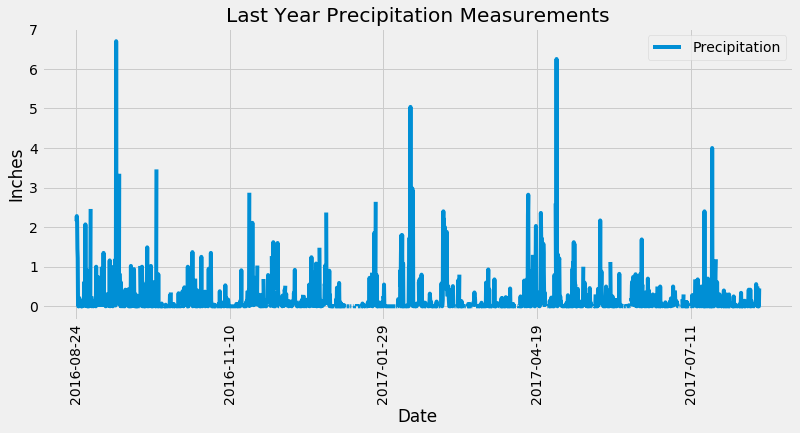

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
last_date = dt.datetime.strptime(last_date, "%Y-%m-%d")
first_date = last_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= first_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(data, columns=['Date', 'Precipitation'])
precipitation_df.set_index(precipitation_df['Date'], inplace=True)
precipitation_df = precipitation_df.drop(columns=['Date'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_index()
precipitation_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(rot=90, figsize=(12,5))
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Last Year Precipitation Measurements')
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
available_stations = session.query(func.count(Station.id)).all()
print('There are ' + str(available_stations[0][0]) + ' available stations')

There are 9 available stations


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station)
active_stations = active_stations.order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

most_active_station = active_stations[0][0]
station_data = session.query(Measurement.tobs).filter(Measurement.station == most_active_station).all()

min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()

print(f'The lowest temp recorded is {min_temp[0][0]} F')
print(f'The highest temp recorded is {max_temp[0][0]} F')
print(f'The average temp is {round(avg_temp[0][0],1)} F')

The lowest temp recorded is 54.0 F
The highest temp recorded is 85.0 F
The average temp is 71.7 F


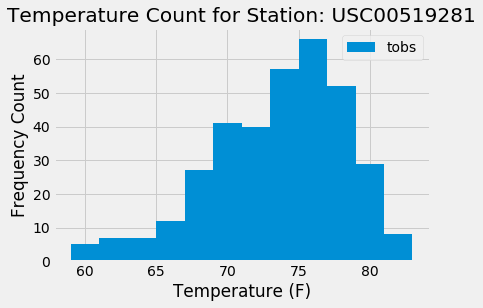

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_observed_station = session.query(Measurement.tobs).filter(Measurement.station == most_active_station).filter(Measurement.date >= first_date).all()
most_observed_station_df = pd.DataFrame(most_observed_station, columns=['tobs'])

most_observed_station_df.plot.hist(bins=12)
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency Count')
plt.title(f'Temperature Count for Station: {most_active_station}')
plt.savefig("Images/Temp_Cout_Station.png")
plt.show()

## Bonus Challenge Assignment

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

arriving_date_ref = dt.date(2021, 5, 5)
leaving_date_ref = dt.date(2021, 5, 20)
four_years_delta = dt.timedelta(days=1461)

arriving_date = arriving_date_ref - four_years_delta
leaving_date = leaving_date_ref - four_years_delta

temp_data = calc_temps(arriving_date, leaving_date)
print(f' The minimum temperature during the trip would be {temp_data[0][0]} F')
print(f' The maximum temperature during the trip would be {temp_data[0][2]} F')
print(f' The average temperature during the trip would be {round(temp_data[0][1],1)} F')


 The minimum temperature during the trip would be 66.0 F
 The maximum temperature during the trip would be 80.0 F
 The average temperature during the trip would be 75.0 F


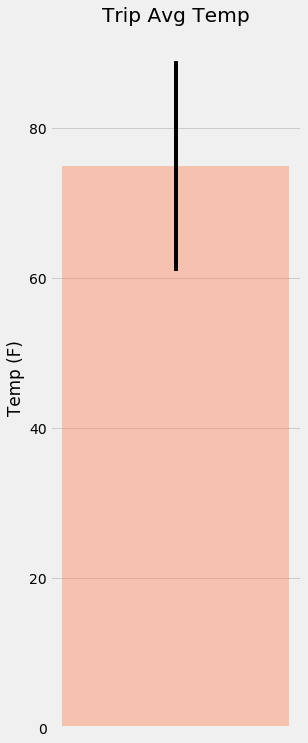

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots(figsize=plt.figaspect(3.))
error = temp_data[0][2] - temp_data[0][0]
plt.bar(0, temp_data[0][1], yerr=error, alpha=0.4, color='coral', align="center")
plt.ylabel('Temp (F)')
plt.title('Trip Avg Temp')
plt.xticks([])
plt.show()

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

results = session.query(Station.station, func.sum(Measurement.prcp), Station.name, Station.latitude, Station.longitude,
                  Station.elevation)
results = results.filter(Measurement.station == Station.station).filter(Measurement.date >= arriving_date).filter(Measurement.date <= leaving_date)
results = results.group_by(Station.station).order_by(func.sum(Measurement.prcp).desc())

print(f"My Trip Dates: From: {arriving_date_ref} To: {leaving_date_ref}")
print("----------------------------------------------------------------")

for row in results:
    rainfall = "{0:.2f}".format(row[1])
    print (f"Station:  {row[0]}\nRainfall:  {rainfall}\nLocation:  {row[2]}\nLatitude:  {row[3]}  \nLongitude:  {row[4]}  Elevation:  {row[5]}\n")
    print("----------------------------------------------------------------")

My Trip Dates: From: 2021-05-05 To: 2021-05-20
----------------------------------------------------------------
Station:  USC00516128
Rainfall:  4.62
Location:  MANOA LYON ARBO 785.2, HI US
Latitude:  21.3331  
Longitude:  -157.8025  Elevation:  152.4

----------------------------------------------------------------
Station:  USC00519281
Rainfall:  3.31
Location:  WAIHEE 837.5, HI US
Latitude:  21.45167  
Longitude:  -157.84888999999998  Elevation:  32.9

----------------------------------------------------------------
Station:  USC00513117
Rainfall:  2.34
Location:  KANEOHE 838.1, HI US
Latitude:  21.4234  
Longitude:  -157.8015  Elevation:  14.6

----------------------------------------------------------------
Station:  USC00514830
Rainfall:  2.04
Location:  KUALOA RANCH HEADQUARTERS 886.9, HI US
Latitude:  21.5213  
Longitude:  -157.8374  Elevation:  7.0

----------------------------------------------------------------
Station:  USC00519523
Rainfall:  1.26
Location:  WAIMANALO EXPER

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip

# push each tuple of calculations into a list called `normals`
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date

trip_dates = pd.date_range(arriving_date, leaving_date)
trip_md = trip_dates.strftime('%m-%d')

normals = []
for trip_date in trip_md:
    normals.append(*daily_normals(trip_date))

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns = ['Tmin', 'Tavg', 'Tmax'])
normals_df['Date'] = trip_dates
normals_df = normals_df.set_index('Date')

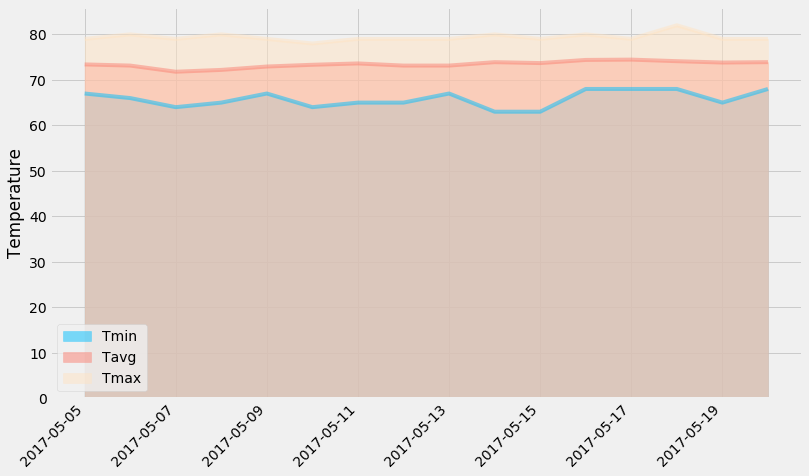

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
colors = ['deepskyblue', 'salmon', 'bisque']
normals_df.plot(kind='area', figsize=(12, 8), stacked=False, x_compat=True, color=colors, alpha=.5, rot=45)
plt.xlabel('')
plt.ylabel('Temperature')
plt.show()